In [ ]:
import pandas as pd 
import fastai

df = pd.read_csv("downloads/40k_balanced_pm_acl.csv").sample(frac=1)
df = df.dropna(subset=["labels"])
df["text_nomask"] = df["text"] #backup
print(len(df))
df_test = df[:300]
df = df[300:]

fastai.__version__, len(df)

42140


('2.5.3', 41840)

In [ ]:
df["text_length"]= df["text"].map(lambda t: len(t.split(" ")))

In [ ]:
df = df[df["text_length"] > 7]


In [ ]:
from octoflow.core import replace_outof_vocab_words, vocab30k

df["text"] = df["text"].map(lambda t: replace_outof_vocab_words(t, vocab30k))
df_test["text"] = df_test["text"].map(lambda t: replace_outof_vocab_words(t,vocab30k))

/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df["text"] = df["text"].astype(str)
df["labels"] = df["labels"].astype(int)

In [ ]:
df = df[(df["labels"] == 1) | (df["labels"] == 0)]
df["lab"] = df["labels"] #worst fastai bug in history

In [ ]:
from fastai.text.all import *
dls = TextDataLoaders.from_df(df, text_col='text', label_col='lab')

dls.show_batch()

learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(beta=1)])


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj from xxmaj january 2016 to xxmaj january 2019 at xxmaj xxunk xxmaj hospital xxmaj affiliated with xxmaj shanghai xxmaj xxunk xxmaj xxunk xxmaj university xxmaj school of xxmaj medicine , 208 donors were recruited and randomly assigned to four groups : xxup s - ripc group ( no intervention ; < i > n < / i > = 55 ) , xxup d - ripc group ( donors received xxup ripc ; < i > n < / i > = 51 ) , xxup r - ripc group ( recipients received xxup ripc , < i > n < / i > = 51 ) and xxup dr - ripc group ( both donors and recipients received xxup ripc ; < i > n < / i > = 51 ) .",0
1,"xxbos xxmaj the study included 90 patients with xxmaj american xxmaj society of xxmaj anesthesiologists ' ( asa ) class i and xxup ii , in good cardiopulmonary health , who were assigned to one of three groups : xxmaj restrictive group , which received 1 ml / kg / hr intraoperatively and six hours postoperatively ; xxmaj low liberal group , which received 5 ml / kg / hr of xxmaj ringer 's solution intraoperatively and six hours postoperatively and xxmaj high liberal group , which received 15 ml / kg / hr intraoperatively and 10 ml / kg / hr six hours postoperatively .",0
2,"xxbos xxmaj in this single - dose , open - label , crossover study , healthy adults ( age range , 18 - 65 years ) were randomized equally to one of six treatment sequences for three 72 - hour treatment periods with xxup gsp301 ( xxunk xxunk μg - mometasone 50 μg ) , the mometasone xxunk monotherapy component of xxup gsp301 ( mf - xxunk , 50 μg ) , and xxup u.s . xxmaj food and xxmaj drug xxmaj administration - approved mometasone ( mf , 50 μg ) ; all the treatments were administered as two xxunk per xxunk .",0
3,"xxbos xxmaj twenty - five patients with advanced cancer pancreas progressed or failed on 1st line treatments and justified the inclusion criteria were eligible to receive xxmaj docetaxel 75 mg / m < sup>2 < / sup > over xxunk iv infusion on day 1 , xxmaj oxaliplatin 80 mg / m < sup>2 < / sup > over 2 h iv infusion on day 2 , the cycle was repeated every 3 weeks for 6 - 8 cycles unless disease progression or severe toxicity appeared .",0
4,xxbos xxmaj this paper contributes to the identification of risk factors for xxup koa progression via a robust feature selection ( xxup fs ) methodology that overcomes two crucial challenges : ( i ) the observed high dimensionality and heterogeneity of the available data that are obtained from the xxmaj osteoarthritis xxmaj initiative ( xxup xxunk ) database and ( ii ) a severe class imbalance problem posed by the fact that the xxup koa xxunk class is significantly smaller than the non - xxunk ' class .,1
5,"xxbos xxmaj the objective of this article is to describe and trigger a serious discussion of such challenges , which include : adopting a new concept of health ; positioning self - rated health as the main outcome of the system ; creating a health - oriented model to guide service provision ; facilitating the identification , scaling up , and sustaining of innovations that can create and spread health ; promoting a culture of health promotion ; and encouraging the emergence of xxmaj precision xxmaj health .",1
6,"xxbos xxmaj the xxunk determined that the main barriers to optimal care of community - based patients with xxup niddm are that 1 ) xxup niddm is not considered or managed as a serious problem by most physicians and their patients ; 2 ) the genetic basis for and refractory nature of obesity are not generally appreciated ; and 3 ) as a complex , multisystemic chronic illness , diabetes xxunk poorly in a health care delivery system designed to deal with acute and episodic illnesses .",1
7,"xxbos xxmaj intimate partner violence ( xxup ipv ) is a serious public health problem that disproportionately affects racial / ethnic minorities in the xxup u.s . xxmaj this study examines risk factors for xxup ipv perpetration that are salient for racial / ethnic minorities ; specifically , we test if racial / ethnic discrim

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.195548,0.103302,0.961329,0.963422,00:21


epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.059184,0.041885,0.985051,0.985896,00:45
1,0.038300,0.028888,0.989004,0.989575,00:46


,text,category,category_
0,"xxbos xxmaj this observational study reviews data on the number of cases of yaws identified by each of the five yaws detection approaches : 1 ) passive yaws detection at local clinics after staff attended xxmaj neglected xxmaj tropical xxmaj disease awareness workshops , 2 ) community - based case detection carried out in remote communities by hospital staff who relied on community health workers to identify cases , 3 ) yaws screening following mass xxmaj xxunk xxmaj ulcer outreach programs being xxunk in the district , 4 ) school - based screening programs conducted as stand - alone and follow - up activities to mass outreach events , and 5 ) house to house active surveillance activities conducted in thirty - eight communities .",0,0
1,"xxbos randomized , prospective single center study , primary setting ; 16 patients with moderate chronic rhinosinusitis with polyps ( xxunk ) , corresponding to a xxmaj lund / xxmaj xxunk score of 6 - 12 ; home based electrostimulation therapy ( est ) with amplitude xxunk current ( base frequency of 4 xxrep 3 0 xxmaj hz , frequency band of 100 - 250 xxmaj hz ) over 2 weeks adjuvant to a concurrent sinusitis therapy with topical corticosteroids ; measurement of nasal nitric oxide concentration and self - assessment of complaints with the questionnaire instrument xxup xxunk xxup xxunk ; survey points t0 before xxup est , t1 after xxup est , t2 6 weeks after t1 .",0,0
2,"xxbos xxmaj the problem with this is that video - feedback teaching of the necessary type is not always available , so we have developed xxunk that we can xxunk out to distant locations , and which focus the attention of both local xxunk and xxunk on what should be learned . xxmaj because it is essential that most of the teaching is done by the live teacher rather than the xxunk , there are always several "" discussion points "" so that xxunk can ask questions , or describe their own way of dealing with particular situations .",1,1
3,"xxbos xxmaj the authors performed a prospective economic substudy alongside the xxup xxunk - timi 54 ( prevention of xxmaj cardiovascular xxmaj events in xxmaj patients xxmaj with xxmaj prior xxmaj heart xxmaj attack xxmaj using xxmaj ticagrelor xxmaj compared to xxmaj placebo on a xxmaj background of aspirin - thrombolysis xxmaj in xxmaj myocardial xxmaj infarction 54 ) trial , which randomized xxunk patients to xxup asa alone , ticagrelor 60 mg twice daily + low - dose xxup asa , or ticagrelor 90 mg twice daily + low - dose xxup asa .",0,0
4,"xxbos a total of xxunk patients were grouped according to their tumor diameter : diameter xxunk cm , xxmaj xxunk ( g < sub > lg < / sub > ) ( n = 30 ) ; diameter 6 to 8 cm , xxmaj xxunk ( g < sub > md < / sub > ) ( n = 57 ) ; and diameter < 6 cm , xxmaj xxunk ( g < sub > sm < / sub > ) ( n = 166 ) .",0,0
5,"xxbos xxmaj with the xxup who now placing global emphasis on the primary prevention of hypertension , the goals of this proof - of - concept study were to ( i ) examine whether sex differences exist in the ambulatory bp - lowering effects of xxup irt in young , normotensive men and women and ( ii ) determine whether these reductions can be predicted by simple laboratory stress tasks ( a 2 - min sustained isometric contraction and a math task involving xxunk a two - digit number from a series of numbers ) .",0,0
6,"xxbos xxmaj twelve women and 16 men , both xxunk trained , performed four sessions in a random order : 1 ) xxup bp followed by xxup lp with three - minutes rest ( xxunk with rest ) ; 2 ) xxup lp followed by xxup bp with three - minutes rest ( xxunk with rest ) ; 3 ) xxup bp followed by xxup lp without rest interval ( xxunk no rest ) , and 4 ) xxup lp followed by xxup bp without rest interval ( xxunk no rest ) .",0,0
7,"xxbos xxmaj evaluation of singlet - singlet energy transfer between tyrosine ( donor ) and tryptophan ( acceptor ) in the biologically active analog i resulted in a low transfer efficiency ( e approximat

,input,target,predicted,probability,loss
0,"xxbos xxmaj in metastatic colorectal cancer , no xxunk or on - treatment markers are available to determine the prognosis or efficacy for chemotherapy in combination with bevacizumab .",1,0,0.999539852142334,7.683861255645752


('0', TensorText(0), TensorText([0.9788, 0.0212]))

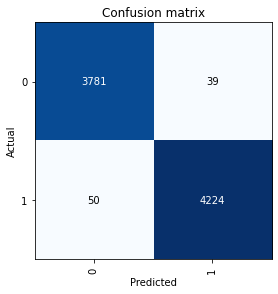

In [ ]:
learn.fine_tune(2, 1e-2)
learn.show_results()


interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(3)  
interp.plot_confusion_matrix()

learn.predict("We discuss the implications of a more 'civic-minded journalism.")

In [ ]:
learn.fine_tune(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.034807,0.032858,0.988386,0.988920,00:24


epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.036854,0.032124,0.989375,0.989930,00:47
1,0.020941,0.033860,0.989128,0.989669,00:48


In [ ]:
learn.export('oct15_40k.pkl')
learn.save("oc15_40k")

Path('models/oc15_40k.pth')

## Sanity Check: Tough Cases
0 = non-problem
1 = problem

In [ ]:
learn.predict("Anaphylaxis is a life-threatening emergency of which reliable epidemiological data are lacking")
#('1', TensorText(1), TensorText([0.0353, 0.9647]))


('0', TensorText(0), TensorText([0.5266, 0.4734]))

In [ ]:
from fastai.vision.all import *
def predict_batch(self, item, rm_type_tfms=None, with_input=False):
    dl = self.dls.test_dl(item, rm_type_tfms=rm_type_tfms, num_workers=0)
    ret = self.get_preds(dl=dl)
    return ret

learn.predict_batch = predict_batch

In [ ]:
predicts = df_test["text"].map(learn.predict)

TypeError: predict_batch() missing 1 required positional argument: 'item'

In [ ]:
df_test["predicted"] = [int(p[0]) for p in predicts]
df_test["confidence_0"] =  [round(p[2][0].item(),2) for p in predicts]
df_test["confidence_1"] =  [round(p[2][1].item(),2) for p in predicts]

In [ ]:
df_test.to_csv("downloads/oct15_40k_test300.csv")

In [ ]:
print("accuracy in test set:", len(df_test[df_test["predicted"] == df_test["labels"]])/len(df_test))

accuracy in test set: 0.9833333333333333


In [ ]:
predicts2 = df_test["text_nomask"].map(learn.predict)

In [ ]:
df_test["predicted2"] = [int(p[0]) for p in predicts2]
print("accuracy in test set with no masking:", len(df_test[df_test["predicted2"] == df_test["labels"]])/len(df_test))

accuracy in test set with no masking: 0.9866666666666667


That's very weird ... masking doesn't effect predictions